# Проект "Дашборд конверсий"

## Шаг 1 Выгрузка из Google

Выгрузим необходимые библиотеки

In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import requests
import plotly.express as px
from dotenv import load_dotenv
import os
import json

load_dotenv()

True

Скачаем и подгрузим данные по указанным ссылкам
Визиты - https://drive.google.com/file/d/1QosQQ4RRNR9rkL4t7sB707h2Uy0XfYJe/view
Регистрации - https://drive.google.com/file/d/1AeQz0kaSgz0lxYSDtuNm36muhy5fRCzZ/view

In [8]:
with open("visits.csv", 'wb') as f:
    f.write(requests.get("https://drive.google.com/uc?id=1QosQQ4RRNR9rkL4t7sB707h2Uy0XfYJe").content)

with open("registrations.csv", 'wb') as f:
    f.write(requests.get("https://drive.google.com/uc?id=1AeQz0kaSgz0lxYSDtuNm36muhy5fRCzZ").content)

visits_df = pd.read_csv("visits.csv")
registrations_df = pd.read_csv("registrations.csv")

print(visits_df.head())
print(registrations_df.head())

                                   uuid platform  \
0  1de9ea66-70d3-4a1f-8735-df5ef7697fb9      web   
1  f149f542-e935-4870-9734-6b4501eaf614      web   
2  f149f542-e935-4870-9734-6b4501eaf614      web   
3  08f0ebd4-950c-4dd9-8e97-b5bdf073eed1      web   
4  08f0ebd4-950c-4dd9-8e97-b5bdf073eed1      web   

                                          user_agent                 date  
0  Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_2...  2023-03-01T13:29:22  
1  Mozilla/5.0 (X11; CrOS x86_64 8172.45.0) Apple...  2023-03-01T16:44:28  
2  Mozilla/5.0 (X11; CrOS x86_64 8172.45.0) Apple...  2023-03-06T06:12:36  
3  Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:109...  2023-03-01T20:16:37  
4  Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:109...  2023-03-05T17:42:47  
                  date  user_id                    email platform  \
0  2023-03-01T00:25:39  8838849     joseph95@example.org      web   
1  2023-03-01T14:53:01  8741065  janetsuarez@example.net      web   
2  2023-03-01T14:27:36  

### Выполним предварительный анализ с помощью dataframe.describe

In [9]:
print("Статистика по визитам")
print(visits_df.describe(include='all'))

print("Статистика по регистрациям")
print(registrations_df.describe(include='all'))

Статистика по визитам
                                        uuid platform  \
count                                   1000     1000   
unique                                   519        3   
top     251a0926-ece3-4d77-aa42-ab569fdf9fe2      web   
freq                                       4      954   

                                               user_agent                 date  
count                                                1000                 1000  
unique                                                 28                  996  
top     Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...  2023-03-01T08:01:45  
freq                                                   71                    2  
Статистика по регистрациям
                       date       user_id                  email platform  \
count                  1000  1.000000e+03                   1000     1000   
unique                 1000           NaN                    997        3   
top     2023-03-01T00:25:39  

## Шаг 2 Выгрузка по API 

In [20]:
%%writefile .env
API_URL=https://data-charts-api.hexlet.app
DATE_BEGIN=2023-03-01
DATE_END=2023-09-01

Writing .env


In [22]:
load_dotenv('.env')

BASE_URL = os.getenv('API_URL')
START_DATE = os.getenv('DATE_BEGIN')
END_DATE = os.getenv('DATE_END')

# Запрашиваем данные по визитам
visits_response = requests.get(f"{BASE_URL}/visits?begin={START_DATE}&end={END_DATE}")
visits_data = visits_response.json()

# Запрашиваем данные по регистрациям
registrations_response = requests.get(f"{BASE_URL}/registrations?begin={START_DATE}&end={END_DATE}")
registrations_data = registrations_response.json()

# Формируем Датафрэймы
visits_df = pd.DataFrame(visits_data)
registrations_df = pd.DataFrame(registrations_data)

print(f"Количество визитов {len(visits_df)}")
print(f"Количество регистраций{len(registrations_df)}")

Количество: 263459 визитов
Количество: 21836 регистраций


## Шаг 3 - Расчет метрик

In [36]:
# 1. Работа с визитами
# Фильтруем ботов
visits_df_filtered = visits_df[~visits_df['user_agent'].str.contains('bot')].copy()

# Преобразуем дату и берем последний визит
visits_df_filtered['datetime'] = pd.to_datetime(visits_df_filtered['datetime'])
visits_df_sorted = visits_df_filtered.sort_values('datetime')
visits_last = visits_df_sorted.groupby('visit_id').last().reset_index()

# Создаем колонку с датой для группировки
visits_last['date_group'] = visits_last['datetime'].dt.date

# Группируем визиты по дате и платформе
visits_grouped = visits_last.groupby(['date_group', 'platform']).size().reset_index(name='visits')

# 2. Работа с регистрациями
registrations_df_copy = registrations_df.copy()

# Преобразуем дату для регистраций
registrations_df_copy['datetime'] = pd.to_datetime(registrations_df_copy['datetime'])
registrations_df_copy['date_group'] = registrations_df_copy['datetime'].dt.date

# Группируем регистрации по дате и платформе
registrations_grouped = registrations_df_copy.groupby(['date_group', 'platform']).size().reset_index(name='registrations')

# 3. Объединяем датафреймы визитов и регистраций
merged_df = pd.merge(visits_grouped, registrations_grouped, on=['date_group', 'platform'], how='left')

# Заполняем пропущенные значения нулями
merged_df['registrations'] = merged_df['registrations'].fillna(0)

# 4. Рассчитываем конверсию
merged_df['conversion'] = (merged_df['registrations'] / merged_df['visits']) * 100

# Сортируем
merged_df = merged_df.sort_values('date_group')

# 5. Сохраняем в JSON
merged_df.to_json('./conversion.json')

print("Данные обработаны и сохранены в conversion.json")

Данные обработаны и сохранены в conversion.json


## Шаг 4 Добавляем рекламы

In [31]:
# Читаем файл ads.csv из директории проекта
ads_df = pd.read_csv('./ads.csv')

# Преобразуем дату
ads_df['date_group'] = pd.to_datetime(ads_df['date']).dt.date

# Группируем рекламные данные по дате и кампании
ads_grouped = ads_df.groupby(['date_group', 'utm_campaign'])['cost'].sum().reset_index()

# Визиты группируем по дате
visits_by_date = visits_df.groupby('date_group').size().reset_index(name='visits')

# Регистрации группируем по дате  
registrations_by_date = registrations_df.groupby('date_group').size().reset_index(name='registrations')

# Объединяем визиты и регистрации. Объединяем с рекламой
conversions_by_date = pd.merge(visits_by_date, registrations_by_date, on='date_group', how='left')
conversions_by_date['registrations'] = conversions_by_date['registrations'].fillna(0)
final_ads_df = pd.merge(conversions_by_date, ads_grouped, on='date_group', how='left')

# Заполняем пропущенные значения
final_ads_df['utm_campaign'] = final_ads_df['utm_campaign'].fillna('none')
final_ads_df['cost'] = final_ads_df['cost'].fillna(0)

# Сортируем
final_ads_df = final_ads_df.sort_values('date_group')
print(final_ads_df.head(10))

# Сохраняем в JSON
final_ads_df.to_json('./ads.json', orient='records')

print("Данные обработаны и сохранены в ads.json")

   date_group  visits  registrations                utm_campaign   cost
0  2023-03-01     376             87  advanced_algorithms_series  212.0
1  2023-03-02     613            106  advanced_algorithms_series  252.0
2  2023-03-03     683            107  advanced_algorithms_series  202.0
3  2023-03-04     647            159  advanced_algorithms_series  223.0
4  2023-03-05     707            115  advanced_algorithms_series  265.0
5  2023-03-06    1291            230  advanced_algorithms_series  108.0
6  2023-03-07    1382            124  advanced_algorithms_series  165.0
7  2023-03-08    1382            151  advanced_algorithms_series  155.0
8  2023-03-09    1064            209  advanced_algorithms_series  124.0
9  2023-03-10     812            112  advanced_algorithms_series  276.0


## Шаг 5 Визуализация

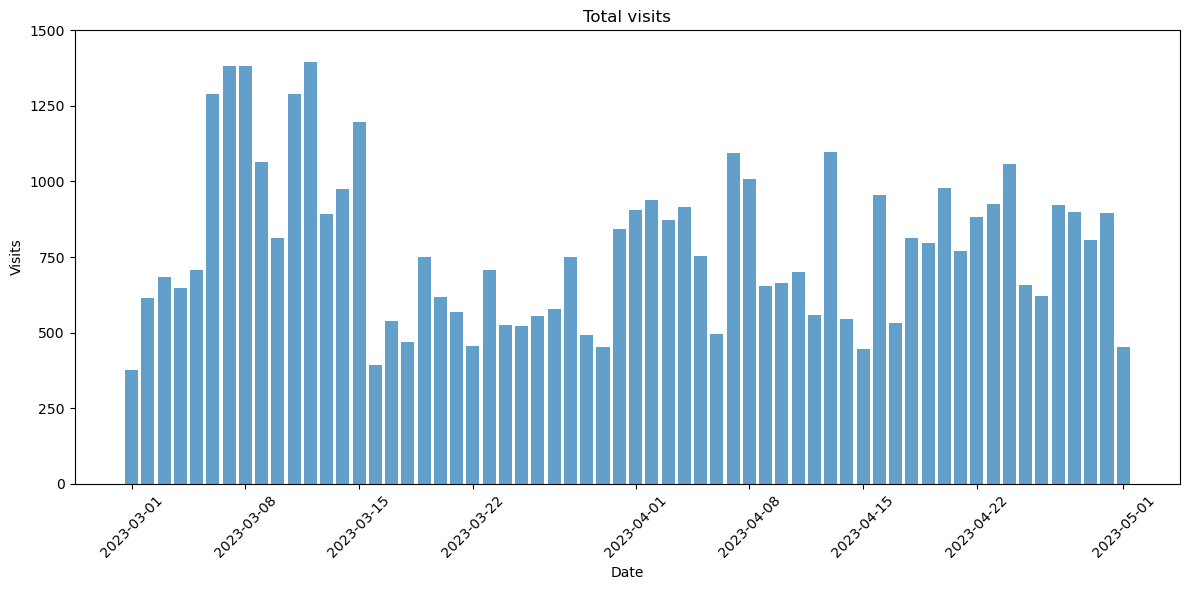

<Figure size 1200x600 with 0 Axes>

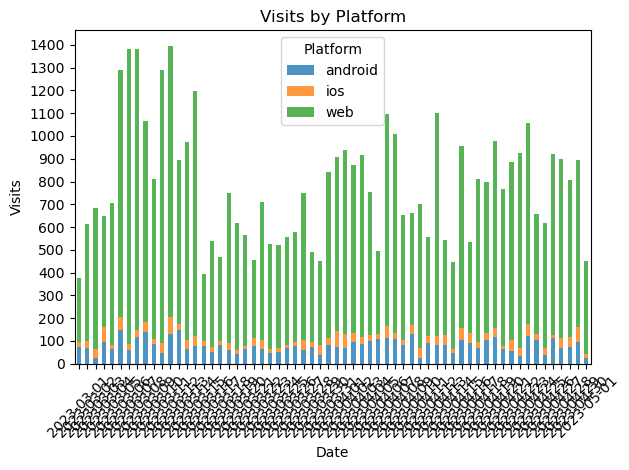

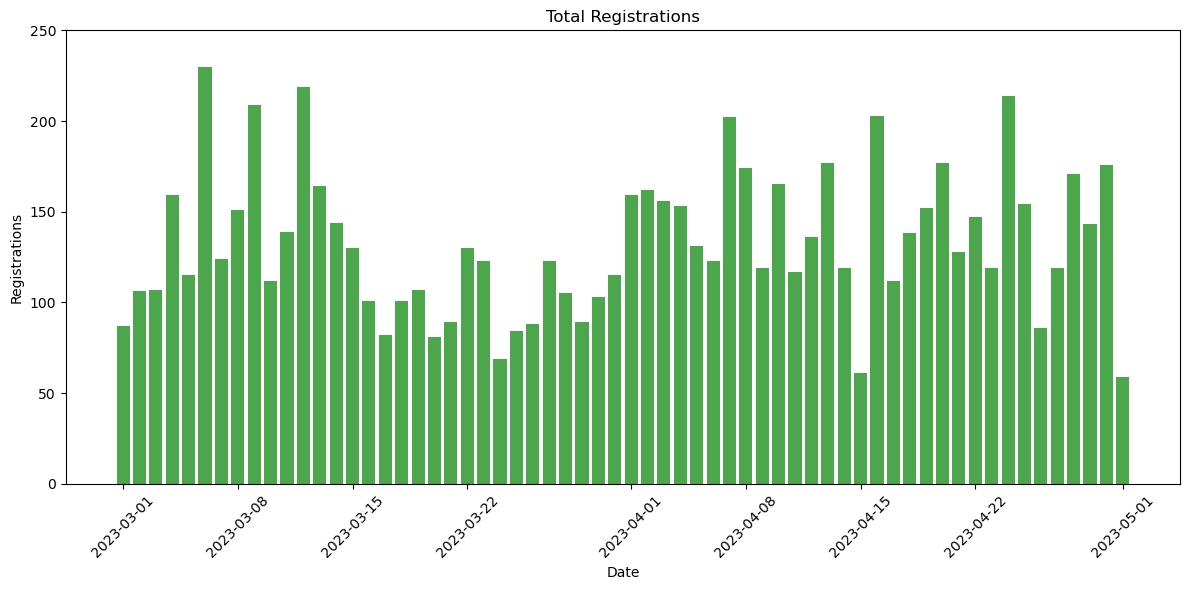

<Figure size 1200x600 with 0 Axes>

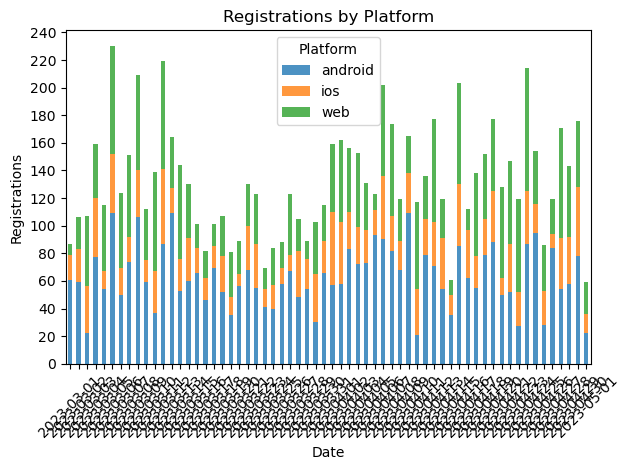

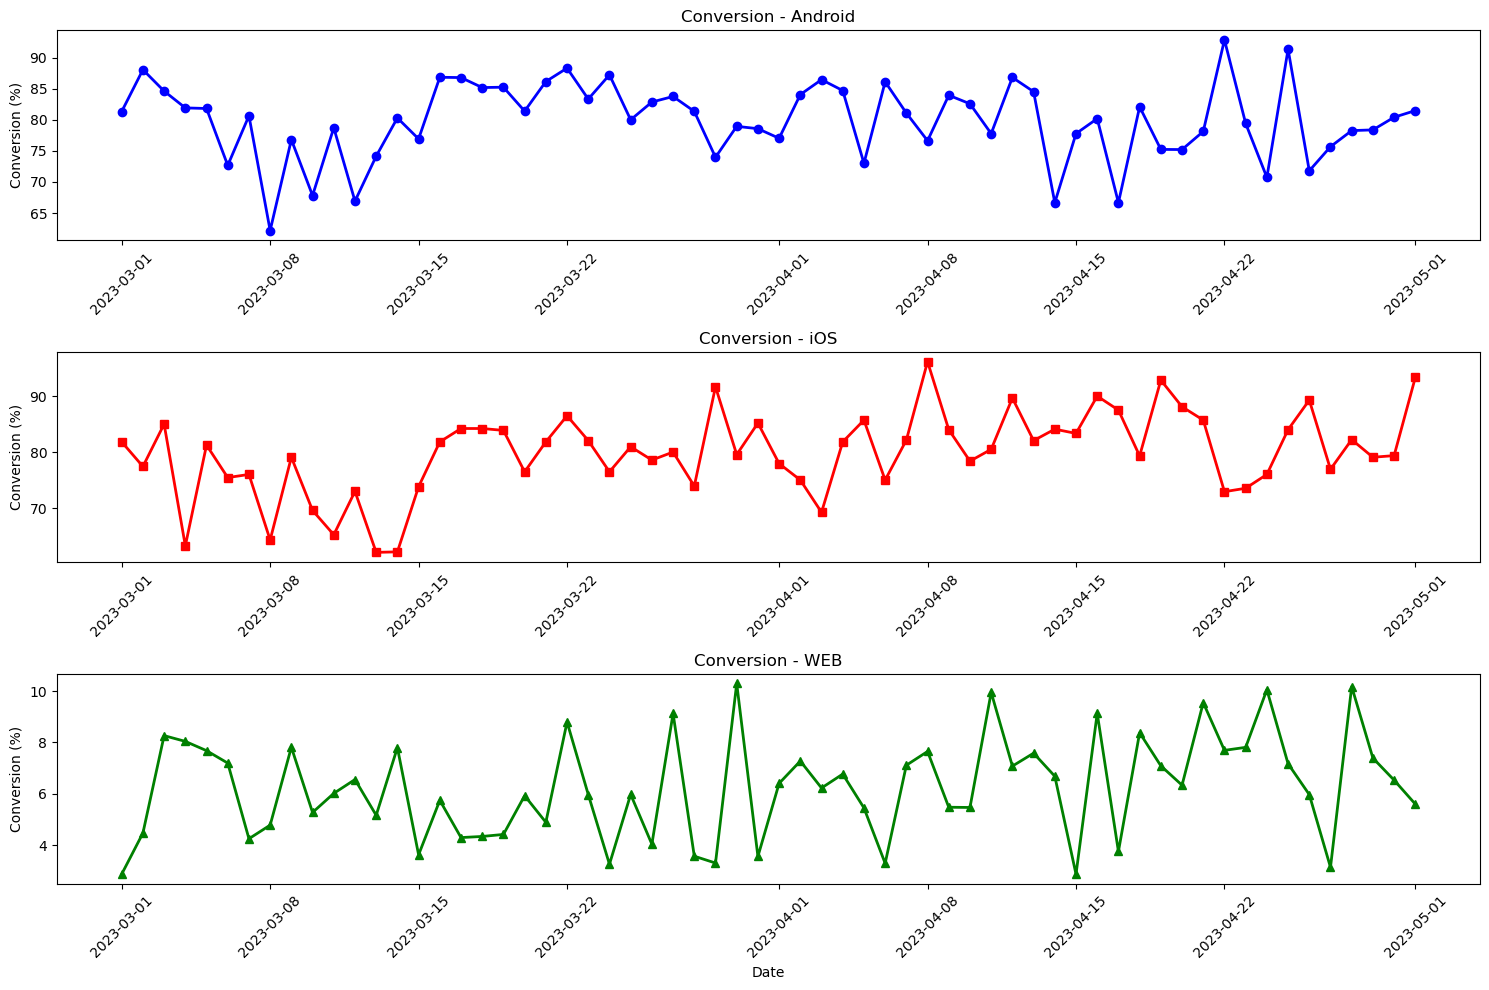

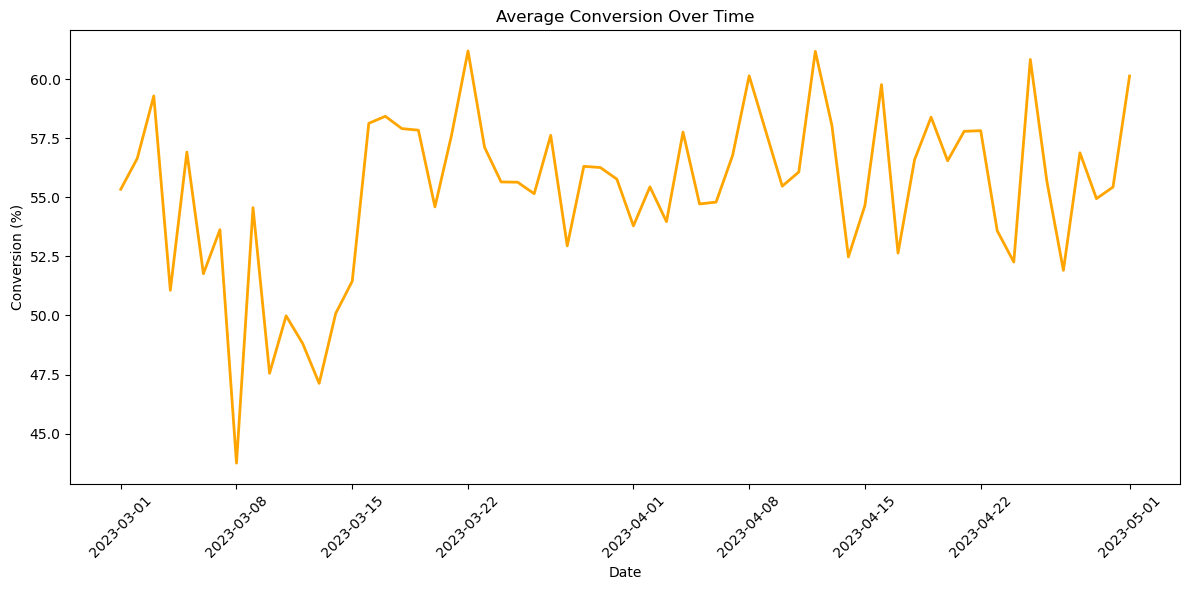

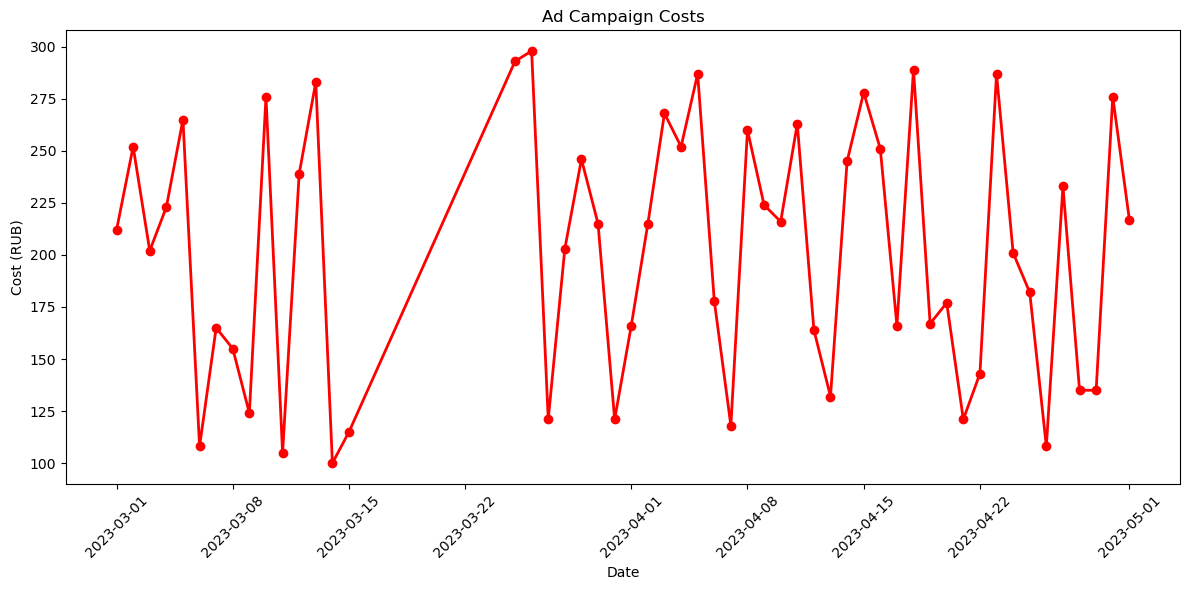

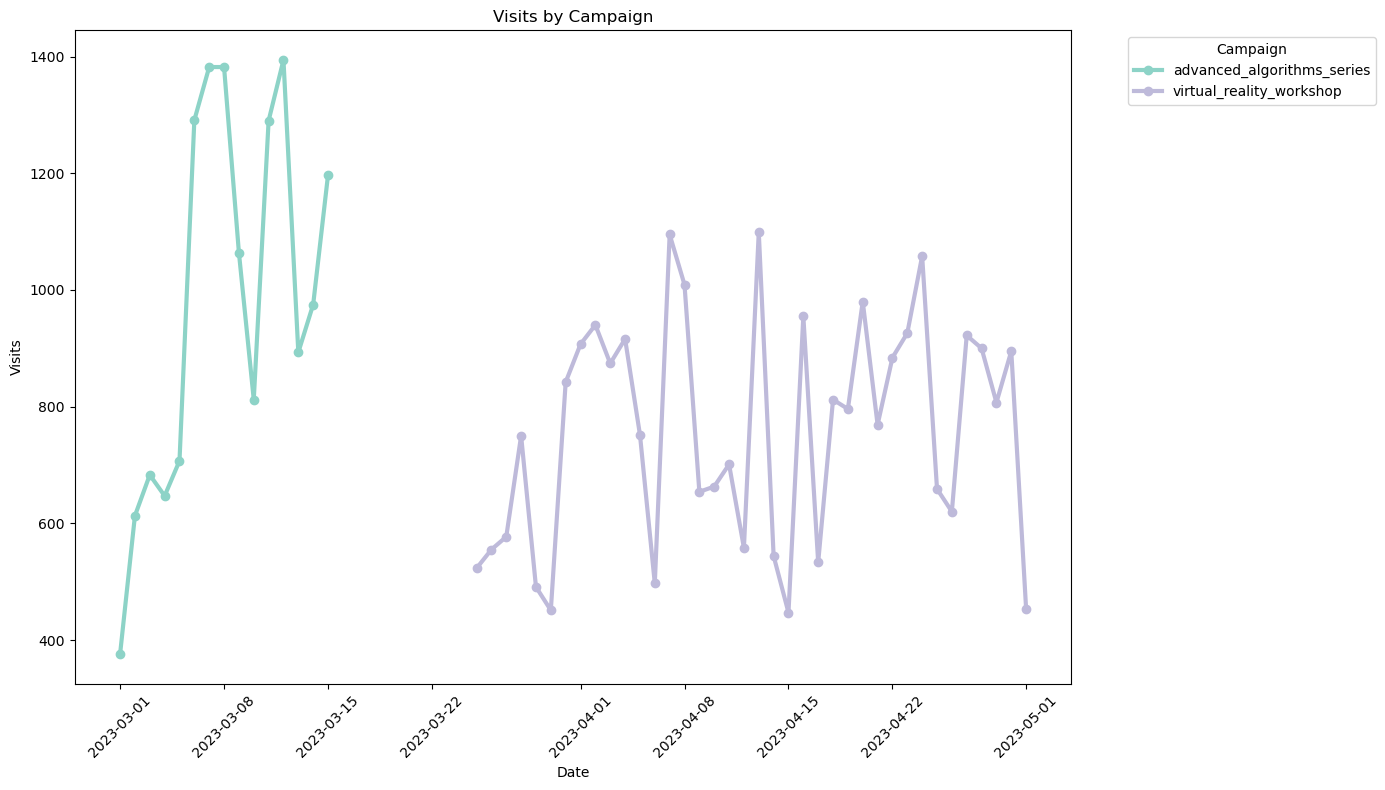

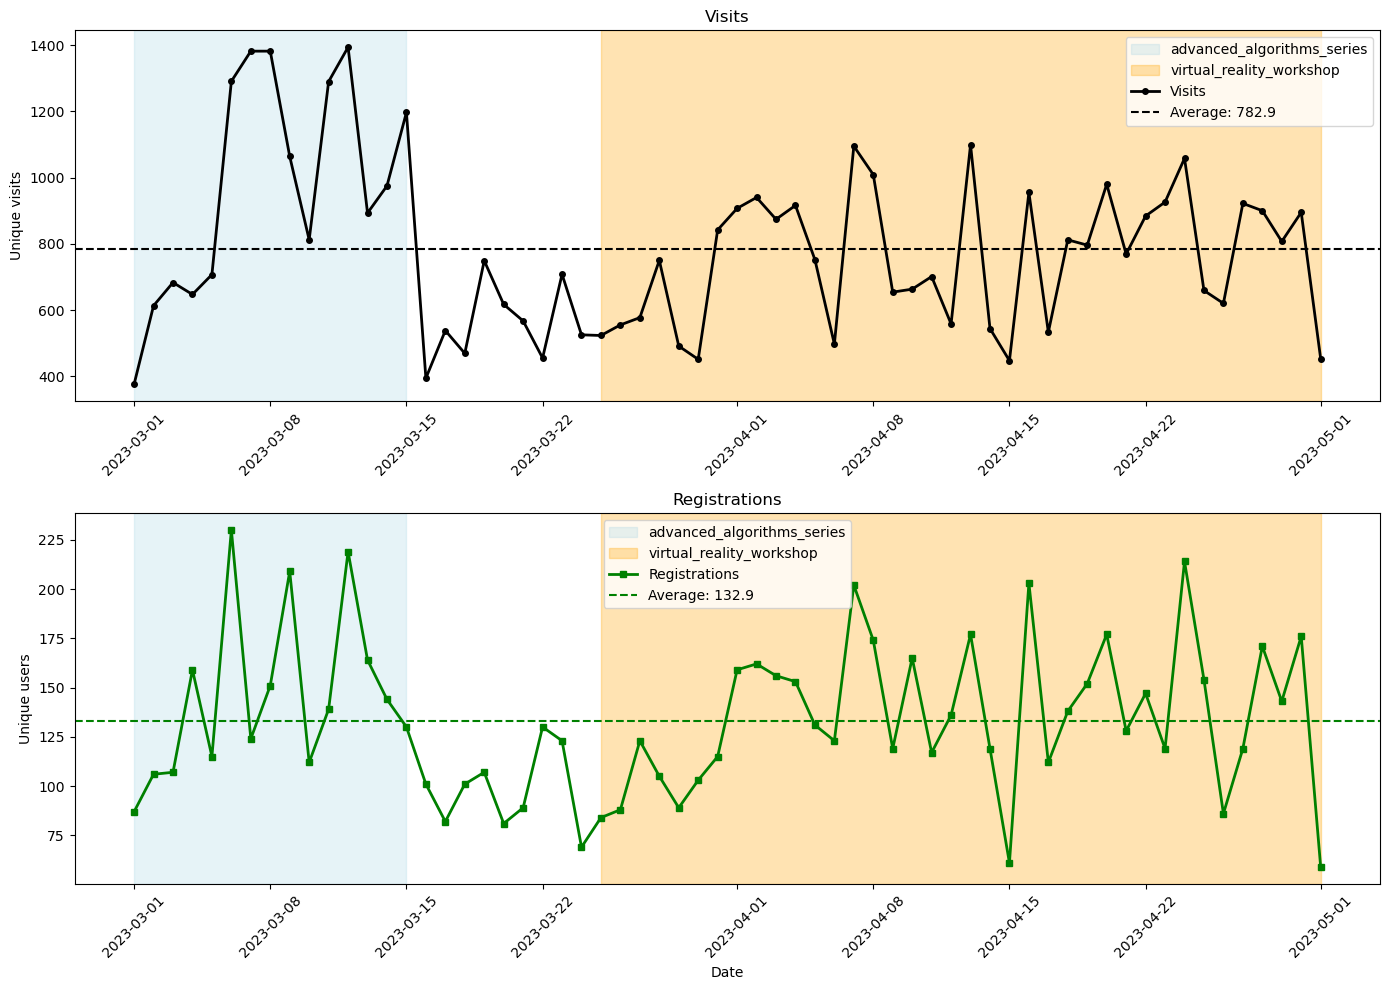

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pandas as pd
import numpy as np
from datetime import datetime

# Создаем папку для визуализаций
os.makedirs('./charts', exist_ok=True)


# 1. Итоговые визиты
plt.figure(figsize=(12, 6))
visits_by_date = visits_df.groupby('date_group').size()
plt.bar(visits_by_date.index, visits_by_date.values, alpha=0.7)
max_y = visits_by_date.max()
y_ticks = np.arange(0, max_y + 250, 250)
plt.yticks(y_ticks)
plt.title('Total visits')
plt.xlabel('Date')
plt.ylabel('Visits')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('./charts/Total_visits.png')
plt.show()

# 2. Итоговые визиты с разбивкой по платформам: web, android, ios
plt.figure(figsize=(12, 6))
visits_by_platform = visits_df.groupby(['date_group', 'platform']).size().unstack()
visits_by_platform.plot(kind='bar', stacked=True, alpha=0.8)
max_y = visits_by_platform.sum(axis=1).max()
y_ticks = np.arange(0, max_y + 100, 100)
plt.yticks(y_ticks)
plt.title('Visits by Platform')
plt.xlabel('Date')
plt.ylabel('Visits')
plt.legend(title='Platform')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('./charts/Visits_by_Platform.png')
plt.show()

# 3. Итоговые регистрации
plt.figure(figsize=(12, 6))
registrations_by_date = registrations_df.groupby('date_group').size()
plt.bar(registrations_by_date.index, registrations_by_date.values, color='green', alpha=0.7)
max_y = registrations_by_date.max()
y_ticks = np.arange(0, max_y + 50, 50)
plt.yticks(y_ticks)
plt.title('Total Registrations')
plt.xlabel('Date')
plt.ylabel('Registrations')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('./charts/Total_Registrations.png')
plt.show()

# 4. Итоговые регистрации с разбивкой по платформе: web, android, ios
plt.figure(figsize=(12, 6))
registrations_by_platform = registrations_df.groupby(['date_group', 'platform']).size().unstack()
registrations_by_platform.plot(kind='bar', stacked=True, alpha=0.8)
max_y = registrations_by_platform.sum(axis=1).max()
y_ticks = np.arange(0, max_y + 20, 20)
plt.yticks(y_ticks)
plt.title('Registrations by Platform')
plt.xlabel('Date')
plt.ylabel('Registrations')
plt.legend(title='Platform')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('./charts/Registrations_by_Platform.png')
plt.show()

# 5. Конверсия по каждой платформе
plt.figure(figsize=(15, 10))

# Android
plt.subplot(3, 1, 1)
android_data = merged_df[merged_df['platform'] == 'android']
plt.plot(android_data['date_group'], android_data['conversion'], linewidth=2, color='blue', marker='o')
plt.title('Conversion - Android')
plt.ylabel('Conversion (%)')
plt.xticks(rotation=45)

# iOS
plt.subplot(3, 1, 2)
ios_data = merged_df[merged_df['platform'] == 'ios']
plt.plot(ios_data['date_group'], ios_data['conversion'], linewidth=2, color='red', marker='s')
plt.title('Conversion - iOS')
plt.ylabel('Conversion (%)')
plt.xticks(rotation=45)

# Web
plt.subplot(3, 1, 3)
web_data = merged_df[merged_df['platform'] == 'web']
plt.plot(web_data['date_group'], web_data['conversion'], linewidth=2, color='green', marker='^')
plt.title('Conversion - WEB')
plt.xlabel('Date')
plt.ylabel('Conversion (%)')
plt.xticks(rotation=45)

plt.tight_layout()
plt.savefig('./charts/Conversion_by_platform.png')
plt.show()

# 6. Средняя конверсия
plt.figure(figsize=(12, 6))
conversion_over_time = merged_df.groupby('date_group')['conversion'].mean()
plt.plot(conversion_over_time.index, conversion_over_time.values, linewidth=2, color='orange')
plt.title('Average Conversion Over Time')
plt.xlabel('Date')
plt.ylabel('Conversion (%)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('./charts/Average_Conversion.png')
plt.show()

# 7. Стоимости реклам
plt.figure(figsize=(12, 6))
ads_with_costs = final_ads_df[final_ads_df['cost'] > 0]
plt.plot(ads_with_costs['date_group'], ads_with_costs['cost'], linewidth=2, color='red', marker='o')
plt.title('Ad Campaign Costs')
plt.xlabel('Date')
plt.ylabel('Cost (RUB)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('./charts/Ad_Campaign_Costs.png')
plt.show()

# 8. Визиты за весь период с цветовым выделением рекламной кампании
plt.figure(figsize=(14, 8))
campaigns = final_ads_df['utm_campaign'].unique()
campaign_colors = plt.cm.Set3(range(len(campaigns)))
color_map = {camp: campaign_colors[i] for i, camp in enumerate(campaigns)}
color_map['none'] = 'lightgray'

for campaign in campaigns:
    if campaign != 'none':
        campaign_data = final_ads_df[final_ads_df['utm_campaign'] == campaign]
        plt.plot(campaign_data['date_group'], campaign_data['visits'], 
                linewidth=3, marker='o', label=campaign, color=color_map[campaign])

plt.title('Visits by Campaign')
plt.xlabel('Date')
plt.ylabel('Visits')
plt.xticks(rotation=45)
plt.legend(title='Campaign', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig('./charts/Visits_by_Campaign.png', bbox_inches='tight')
plt.show()

# 9. Два графика: визиты и регистрации с выделением кампаний
plt.figure(figsize=(14, 10))

# Первый график - Визиты
plt.subplot(2, 1, 1)

# Выделяем периоды кампаний цветом
campaign1_data = final_ads_df[final_ads_df['utm_campaign'] == 'advanced_algorithms_series']
if len(campaign1_data) > 0:
    start1 = campaign1_data['date_group'].min()
    end1 = campaign1_data['date_group'].max()
    plt.axvspan(start1, end1, alpha=0.3, color='lightblue', label='advanced_algorithms_series')

campaign2_data = final_ads_df[final_ads_df['utm_campaign'] == 'virtual_reality_workshop']
if len(campaign2_data) > 0:
    start2 = campaign2_data['date_group'].min()
    end2 = campaign2_data['date_group'].max()
    plt.axvspan(start2, end2, alpha=0.3, color='orange', label='virtual_reality_workshop')

# Рисуем линию визитов с точками
plt.plot(final_ads_df['date_group'], final_ads_df['visits'], 
         color='black', linewidth=2, marker='o', markersize=4, label='Visits')

# Рисуем среднюю линию визитов
avg_visits = final_ads_df['visits'].mean()
plt.axhline(y=avg_visits, color='black', linestyle='--', label=f'Average: {avg_visits:.1f}')

plt.title('Visits')
plt.ylabel('Unique visits')
plt.xticks(rotation=45)
plt.legend()

# Второй график - Регистрации
plt.subplot(2, 1, 2)

# Выделяем те же кампании
if len(campaign1_data) > 0:
    plt.axvspan(start1, end1, alpha=0.3, color='lightblue', label='advanced_algorithms_series')

if len(campaign2_data) > 0:
    plt.axvspan(start2, end2, alpha=0.3, color='orange', label='virtual_reality_workshop')

# Рисуем линию регистраций с точками
plt.plot(final_ads_df['date_group'], final_ads_df['registrations'], 
         color='green', linewidth=2, marker='s', markersize=4, label='Registrations')

# Рисуем среднюю линию регистраций
avg_reg = final_ads_df['registrations'].mean()
plt.axhline(y=avg_reg, color='green', linestyle='--', label=f'Average: {avg_reg:.1f}')

plt.title('Registrations')
plt.xlabel('Date')
plt.ylabel('Unique users')
plt.xticks(rotation=45)
plt.legend()

plt.tight_layout()
plt.savefig('./charts/Registrations_and_Visits_by_Campaign.png')
plt.show()